In [1]:
from unityagents import UnityEnvironment
import numpy as np
import os
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
from ddpg_agent import Agent

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

env = UnityEnvironment(file_name='./Reacher_Linux/Reacher.x86_64')

## get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size

# examine the state space 
state = env_info.vector_observations[0]
state_size = len(state)

print("action_size: {} state_size: {}".format(action_size,state_size))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


action_size: 4 state_size: 33


In [3]:
## define ddpg
def ddpg(my_agent,n_episodes=2000, max_t=10000):
   
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores

    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        my_agent.reset()
        
        state = env_info.vector_observations[0]
        score = 0
        
        for t in range(max_t):
            
            # agent chooses action
            action=my_agent.act(state)
            
            # interact with environment
            env_info = env.step(action)[brain_name]
            (next_state,reward,done) = (
                env_info.vector_observations[0],
                env_info.rewards[0],
                env_info.local_done[0])
             
            # update agent
            my_agent.step(state, action, reward, next_state, done)                     

            state = next_state
            score += reward
               
            if done:
                break 
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
 
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        if np.mean(scores_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
             
            torch.save(my_agent.actor_local.state_dict(), 'checkpoint_my_actor.pth')
            torch.save(my_agent.critic_local.state_dict(), 'checkpoint_my_critic.pth')
            break

    with open('results.txt','a') as fh:
        fh.write(str(scores))
        fh.write("\n")
        fh.write(str(scores[-1]))
        fh.write("\n")
    
    return scores

In [4]:
def run_trial(config):
    
    ## setup my agent
    agent_config = config['agent_config']
    my_agent = Agent(**agent_config)

    ## run the agent
    all_scores = ddpg(
        my_agent,
        **config['ddpg_config']
    )
    
    ## graph scores here
    plt.plot(all_scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #');
    
    return all_scores

Episode 10	Average Score: 0.95
Episode 20	Average Score: 0.87
Episode 30	Average Score: 1.29
Episode 40	Average Score: 1.55
Episode 50	Average Score: 1.97
Episode 60	Average Score: 2.55
Episode 70	Average Score: 3.56
Episode 80	Average Score: 4.98
Episode 90	Average Score: 7.15
Episode 100	Average Score: 9.27
Episode 110	Average Score: 12.74
Episode 120	Average Score: 16.28
Episode 130	Average Score: 19.64
Episode 140	Average Score: 22.75
Episode 150	Average Score: 25.67
Episode 160	Average Score: 28.14
Episode 169	Average Score: 30.13
Environment solved in 69 episodes!	Average Score: 30.13


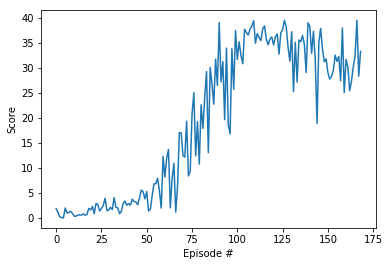

In [7]:
cfg = {
        'ddpg_config':{ 
            'n_episodes':200,
            'max_t':2000,
        },
        'agent_config':{
            'state_size':state_size,
            'action_size':action_size,
            'random_seed':123,
            'buffer_size':10000,  # replay buffer size
            'batch_size':64,        # minibatch size
            'lr_actor':.002,
            'lr_critic':.0001,
            'gamma':0.99,
            'tau':.001,
            'weight_decay':0.0000,
            'ou_theta':0.15,
            'ou_sigma':0.2,
            'actor_nn':[256,256],
            'critic_nn':[256,256,128],
            'epsilon':1.0,
            'epsilon_decay':0.0,
            'update_every':20,
            'num_updates':10,
            'hard_copy':1,
            
        }
    }

with open('results.txt','a') as fh:
    fh.write(str(cfg))
    fh.write("\n")
    
all_scores=run_trial(cfg)

In [ ]:
## close up shop
env.close()